In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint
import simplekml


# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Call the USGS turbine database API

## Add the response to a DataFrame

In [2]:
base_url="https://eersc.usgs.gov/api/uswtdb/v1/turbines"

In [3]:
response = requests.get(base_url).json()

In [10]:
df = pd.DataFrame(response)
df

,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,...,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,eia_id,retrofit,retrofit_year
0,3001247,None,None,5115.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36819,35.07579,52161.0,0,NaN
1,3009410,None,None,5116.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36809,35.07589,52161.0,0,NaN
2,3072670,None,None,5112.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36841,35.07554,52161.0,0,NaN
3,3072663,None,None,5114.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36820,35.07570,52161.0,0,NaN
4,3072661,None,None,5149.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36376,35.07791,52161.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68787,3108971,None,2020-WTW-3724-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2021.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.29768,27.09550,NaN,0,NaN
68788,3109386,None,2020-WTW-3723-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.28698,27.09672,NaN,0,NaN
68789,3106411,48-174404,2019-WTW-10988-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.28335,27.15668,NaN,0,NaN
68790,3109758,None,2019-WTW-10984-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.32201,27.12558,NaN,0,NaN


# Remove irrelevant columns for analysis

In [11]:
df.keys()

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 't_state', 't_county',
       't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu', 't_model',
       't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_conf_atr', 't_conf_loc',
       't_img_date', 't_img_srce', 'xlong', 'ylat', 'eia_id', 'retrofit',
       'retrofit_year'],
      dtype='object')

In [12]:
df = df.drop(columns=['case_id','faa_ors','faa_asn','usgs_pr_id','t_fips','t_rsa','t_cap','t_ttlh','t_conf_atr', 't_conf_loc','t_img_date', 't_img_srce','eia_id', 'retrofit','retrofit_year'])

In [13]:
df = df.rename(columns={'t_state':'State','t_county':'County','p_name':'Wind Farm Name','p_year': 'Year',
                       'p_tnum':'Turbine Count','p_cap':'WF Total MW','t_manu':'Turbine Manufacturer',
                       't_model':'Turbine Model','t_hh': 'Turbine Hub Height','t_rd':'Rotor Diameter','xlong':'lng','ylat':'lat'})

In [14]:
df

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat
0,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36819,35.07579
1,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36809,35.07589
2,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36841,35.07554
3,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36820,35.07570
4,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36376,35.07791
...,...,...,...,...,...,...,...,...,...,...,...,...
68787,TX,Zapata County,unknown Zapata County,2021.0,41,NaN,None,None,NaN,NaN,-99.29768,27.09550
68788,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.28698,27.09672
68789,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.28335,27.15668
68790,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.32201,27.12558


In [15]:
#Clean data frame for wind farms built from 2000 forward
modern_WF = df.loc[df['Year']>=2000.0]
modern_WF =modern_WF.reset_index(drop=True)
len(modern_WF['Wind Farm Name'].unique())

1574

In [25]:
#Clean unkown wind farm


duplicate_df=modern_WF.duplicated('Wind Farm Name')
modern_WF['Duplicated']=duplicate_df.values
index_value = modern_WF[modern_WF['Duplicated']==True].index

modern_WF_clean = modern_WF.drop(index=modern_WF.index[index_value])

modern_WF_clean

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,Duplicated
0,IA,Boone County,30 MW Iowa DG Portfolio,2017.0,10,30.00,Nordex,AW125/3000,87.5,125.0,-93.70042,41.97761,False
10,MA,Barnstable County,6th Space Warning Squadron,2013.0,2,3.36,GE Wind,GE1.68-82.5,80.0,82.5,-70.54180,41.75249,False
12,MA,Barnstable County,AFCEE MMR Turbines,2011.0,2,3.00,GE Wind,GE1.5-77,80.0,77.0,-70.54530,41.75759,False
14,IA,Story County,AG Land 1,2012.0,6,9.60,GE Wind,GE1.6-82.5,80.0,82.5,-93.32569,42.20639,False
15,IA,Story County,AG Land 2,2012.0,6,9.60,GE Wind,GE1.6-82.5,80.0,82.5,-93.42809,42.14609,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63151,TX,Wilbarger County,unknown Wilbarger County,2018.0,6,NaN,None,None,NaN,NaN,-99.41830,34.28581,False
63390,NY,Wyoming County,unknown Wyoming County,2016.0,1,NaN,None,None,NaN,NaN,-78.18794,42.74082,False
63391,TX,Young County,unknown Young County 1,2011.0,1,NaN,None,None,NaN,NaN,-98.55109,33.09329,False
63392,CO,Yuma County,unknown Yuma County,2016.0,2,NaN,None,None,NaN,NaN,-102.71695,40.03755,False


In [32]:
#drop NA Total MW

modern_WF_MW = modern_WF_clean.dropna(subset=['WF Total MW'])
modern_WF_MW

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,Duplicated
0,IA,Boone County,30 MW Iowa DG Portfolio,2017.0,10,30.00,Nordex,AW125/3000,87.5,125.0,-93.70042,41.97761,False
10,MA,Barnstable County,6th Space Warning Squadron,2013.0,2,3.36,GE Wind,GE1.68-82.5,80.0,82.5,-70.54180,41.75249,False
12,MA,Barnstable County,AFCEE MMR Turbines,2011.0,2,3.00,GE Wind,GE1.5-77,80.0,77.0,-70.54530,41.75759,False
14,IA,Story County,AG Land 1,2012.0,6,9.60,GE Wind,GE1.6-82.5,80.0,82.5,-93.32569,42.20639,False
15,IA,Story County,AG Land 2,2012.0,6,9.60,GE Wind,GE1.6-82.5,80.0,82.5,-93.42809,42.14609,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61213,OH,Hancock County,Zephyr Wind Project 2.0,2019.0,3,4.50,Goldwind,GW87,80.0,87.0,-83.63660,41.08840,False
61216,NY,Ontario County,Zotos,2011.0,2,3.30,Hyundai,HQ1650,70.0,82.0,-76.96765,42.88625,False
61221,VT,Addison County,unknown Addison County,2013.0,1,0.10,Northern Power Systems,NPS-100,37.0,21.0,-73.31070,44.00279,False
61935,TX,El Paso County,unknown El Paso County,2015.0,2,3.40,GE Wind,GE1.7-100,80.0,100.0,-106.40543,31.78812,False


# Save the wind farms to a kml file

In [34]:
kml = simplekml.Kml()
modern_WF_MW.apply(lambda X: kml.newpoint(name=X["Wind Farm Name"], coords=[( X["lng"],X["lat"])]) ,axis=1)
kml.save("WF_US.kml")

# Plot wind farm installed capacity trends

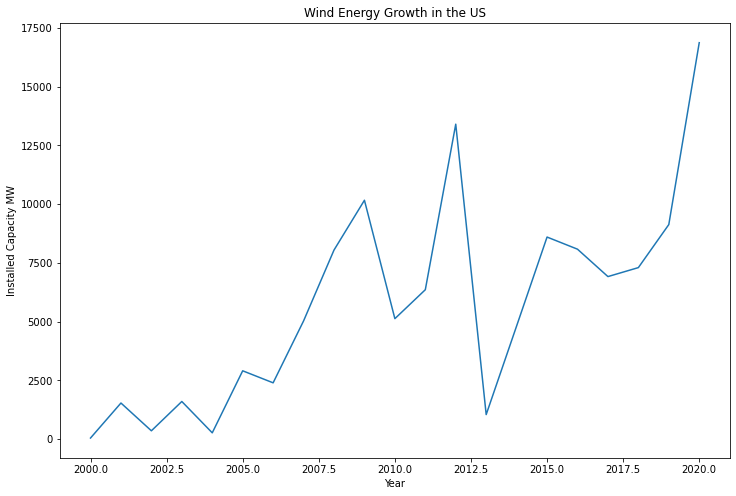

In [35]:
WF_year = modern_WF_MW.groupby('Year')
MW_year = WF_year['WF Total MW'].sum()
x = MW_year.index
y = MW_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y)
plt.xlabel('Year')
plt.ylabel('Installed Capacity MW')
plt.title('Wind Energy Growth in the US')
plt.show()

# Plot wind farm installed capacity by state

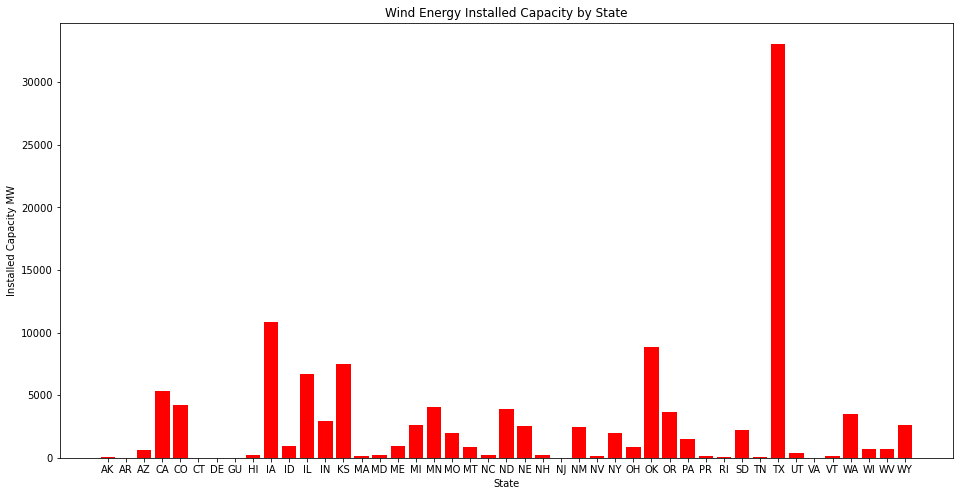

In [36]:
WF_state = modern_WF_MW.groupby('State')
WF_state_MW = WF_state['WF Total MW'].sum()
x = WF_state_MW.index
y = WF_state_MW.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='r')
plt.xlabel('State')
plt.ylabel('Installed Capacity MW')
plt.title('Wind Energy Installed Capacity by State')
plt.show()

In [37]:
coords = []
cities = []
       
#Generate a random list of 500+ cities
lat = modern_WF_MW['lat']
lng = modern_WF_MW['lng']
coords = list(zip(lat,lng))

for coord in coords:
    cityname = citipy.nearest_city(float(coord[0]), float(coord[1])).city_name
    cities.append(cityname)

In [38]:
modern_WF_MW = modern_WF_MW.drop(columns=['Duplicated'])
modern_WF_MW['City'] = cities
modern_WF_MW

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,City
0,IA,Boone County,30 MW Iowa DG Portfolio,2017.0,10,30.00,Nordex,AW125/3000,87.5,125.0,-93.70042,41.97761,ames
10,MA,Barnstable County,6th Space Warning Squadron,2013.0,2,3.36,GE Wind,GE1.68-82.5,80.0,82.5,-70.54180,41.75249,sandwich
12,MA,Barnstable County,AFCEE MMR Turbines,2011.0,2,3.00,GE Wind,GE1.5-77,80.0,77.0,-70.54530,41.75759,sandwich
14,IA,Story County,AG Land 1,2012.0,6,9.60,GE Wind,GE1.6-82.5,80.0,82.5,-93.32569,42.20639,ames
15,IA,Story County,AG Land 2,2012.0,6,9.60,GE Wind,GE1.6-82.5,80.0,82.5,-93.42809,42.14609,ames
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61213,OH,Hancock County,Zephyr Wind Project 2.0,2019.0,3,4.50,Goldwind,GW87,80.0,87.0,-83.63660,41.08840,findlay
61216,NY,Ontario County,Zotos,2011.0,2,3.30,Hyundai,HQ1650,70.0,82.0,-76.96765,42.88625,geneva
61221,VT,Addison County,unknown Addison County,2013.0,1,0.10,Northern Power Systems,NPS-100,37.0,21.0,-73.31070,44.00279,middlebury
61935,TX,El Paso County,unknown El Paso County,2015.0,2,3.40,GE Wind,GE1.7-100,80.0,100.0,-106.40543,31.78812,el paso


# Average turbine height trends

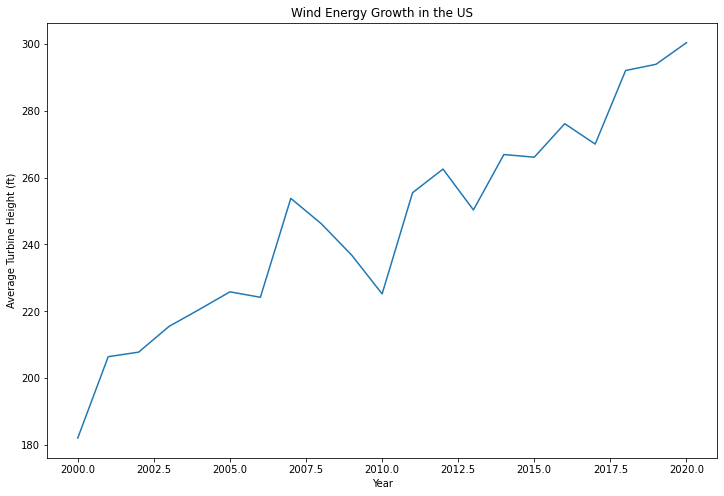

In [39]:
height_year = modern_WF_MW.groupby('Year')
height_year = (height_year['Turbine Hub Height'].mean()) * 3.28084
x = height_year.index
y = height_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y)
plt.xlabel('Year')
plt.ylabel('Average Turbine Height (ft)')
plt.title('Wind Energy Growth in the US')
plt.show()